# This code implements Zero Shot Learning (ZSL) , or learning when NO prior similar Training data has been encountered!

This code uses a modified version of Shrisha Bharadwaj's work at 
https://github.com/sbharadwajj/embarrassingly-simple-zero-shot-learning

The Base paper is:
An embarrassingly simple approach to zero-shot learning http://proceedings.mlr.press/v37/romera-paredes15.pdf


# We start with the Data

### Initially load necessary libraries

In [1]:
import numpy as np
import os
import scipy.io
from sklearn.metrics import classification_report, confusion_matrix

### We'll be using the CUB dataset. CUB referes to Caltech UCSD Birds data set with images of 788 images from 200 different types of birds annotated with 312 attributes.

You can obtain it or similar datasets (such as AWA1 or SUN) [here](https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/research/zero-shot-learning/zero-shot-learning-the-good-the-bad-and-the-ugly/).

## The following cells apply for Google Colab users.
### Run the following cells first. Make sure you've placed the csv data and figures in the same Google Drive folder as this notebook.

In [ ]:
#!pip install -U -q PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

In [ ]:
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

Replace the ID with ID of file you want to access. To get this ID: 

1.   Right-click on the name of the appropriate file in your Google Drive
2.   Click "Get link"
3.   Copy the characters between `d/` and the following slash
4.   Paste them into the dictionary argument of the call to `drive.CreateFile()` as the value associated with the 'id' key. Make sure that this value is a string.



In [ ]:
# Replace the ID with ID of file you want to access
#cub_res101 = drive.CreateFile({'id':'1QSLo_bKWyUTSYbYtGmufwzB2PSFoOJwG'}) 
#cub_res101.GetContentFile('res101.mat') 
#cub_att_splits = drive.CreateFile({'id':'1TtR3H0zfm8NeETRlOKbiSru3rhtdJTey'}) 
#cub_att_splits.GetContentFile('att_splits.mat')

## If you are working on Jupyter notebook, download the CUB folder and put it in the same location as the notebook file.

### From the .mat files extract all the features from resnet and the attribute splits. 
- `res101` contains features and the corresponding labels.
- `att_splits` contains the different splits for trainval:{train, val} and test set. So the `att_splits` data stores locations of the train, validation and test spilt data only.
- `att_splits` contains the labels corresponding to 

In [ ]:
#dataset='CUB'
#res101 = scipy.io.loadmat('./'+dataset+'/res101.mat')
#att_splits = scipy.io.loadmat('./'+dataset+'/att_splits.mat')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
res101 = scipy.io.loadmat('/content/drive/MyDrive/CUB/res101.mat')
att_splits = scipy.io.loadmat('/content/drive/MyDrive/CUB/att_splits.mat')

## Examine the `res101` and `att_splits` dictionaries and understand their fields

In [4]:
res101.keys()

dict_keys(['__header__', '__version__', '__globals__', 'image_files', 'features', 'labels'])

In [5]:
att_splits.keys()

dict_keys(['__header__', '__version__', '__globals__', 'allclasses_names', 'att', 'original_att', 'test_seen_loc', 'test_unseen_loc', 'train_loc', 'trainval_loc', 'val_loc'])

# Let's understand the data sets first:
1. `res101` contains a features array $X$ of shape (`n_features`, `n_samples`) = (2048, 11788). These 11788 samples are divided to train, validation and test. The 2048 features correspond to the FC layer output from resnet 101.
2. Each of the 11788 samples has one of `n_classes` = 200 unique labels.
3. Each label corresponds to an animal that is further represented by a signature/category vector of dimension `n_attributes` = 312.
4. Thus, `att_splits` contains a signature/category array of shape (`n_attributes`, `n_classes`) = (312, 200). Call this $S$.
5. Our goal is to estimate $W = (V \cdot S)^T$ and $\hat{Y} = X^T \cdot V \cdot S = (W \cdot X)^T$. 
6. $V$, in turn, is an array of shape (`n_features`, `n_attributes`) = (2048, 312) which we will compute later.

In [6]:
print(f"Shape of the features array  = {res101['features'].shape}")
print(f"Shape of the signature array = {att_splits['att'].shape}")

Shape of the features array  = (2048, 11788)
Shape of the signature array = (312, 200)


### Verify that our data contains 200 unique labels

In [7]:
labels = res101['labels']
print(np.shape(labels))
print(np.unique(labels))
print(len(np.unique(labels)))

(11788, 1)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200]
200


### We need the corresponding ground-truth labels/classes for each training example for all our train, val, trainval, and test sets according to the split locations provided. In this example we have used the `CUB` dataset, which has 200 unique classes overall.

In [8]:
labels_train = labels[np.squeeze(att_splits['train_loc']-1)]
labels_val = labels[np.squeeze(att_splits['val_loc']-1)]
labels_trainval = labels[np.squeeze(att_splits['trainval_loc']-1)]
labels_test = labels[np.squeeze(att_splits['test_unseen_loc']-1)]

In [9]:
print(np.shape(labels_train))
labels_train[:100,:].T

(4702, 1)


array([[197, 198,  31,  25,  22,  86,  28, 136, 190, 177,  43,  17, 194,
         90,  97,  13,  16,  73,  18, 144,  70,   2, 109, 194,  27, 190,
         18,  43, 106, 149, 169,  27,  47,  67,  90,  18,  75,  57, 172,
         27,  57,  11, 134,  26, 169, 164,  97, 162,  11,   9, 199, 126,
          8,  23,  78,  81,  99, 178,  81, 197,  60,  54,  81, 106,  30,
        106,  17, 181, 198,  25,  27,   2,  22,  16, 103,  54,  28,  27,
        128, 114, 114,  48,  22,  31,  13,  85,   1, 169,  15,   1,  67,
         26,  96, 114,  60,  96,  13,  89,  20, 153]], dtype=uint8)

### In a typical zero-shot learning scenario, there are no overlapping classes between training and testing phase, i.e the train classes are completely different from the test classes. So let us verify if there are any overlapping classes in the test and train scenario. Within each phase/split, we have `n_classes_split` unique classes. 
### Let's verify that all of the labels in our dataset are represented in either our `trainval` or `test` splits that none of the labels in the `trainval` and `test` splits overlap, and likewise that none of the labels in the `train` and `val` splits overlap.

In [10]:
train_labels_seen, train_counts = np.unique(labels_train, return_counts=True)
print(f'Number of unique training labels = {train_labels_seen.shape}')
val_labels_unseen = np.unique(labels_val)
print(f'Number of unique validation labels = {val_labels_unseen.shape}')
trainval_labels_seen, trainval_counts = np.unique(labels_trainval,return_counts=True)
print(f'Number of unique train/validation labels = {trainval_labels_seen.shape}')
test_labels_unseen, test_counts = np.unique(labels_test, return_counts=True)
print(f'Number of unique test labels = {test_labels_unseen.shape}')
print(trainval_counts)

Number of unique training labels = (100,)
Number of unique validation labels = (50,)
Number of unique train/validation labels = (150,)
Number of unique test labels = (50,)
[45 38 37 40 46 48 52 50 51 52 32 48 45 45 42 45 52 50 48 46 44 46 47 49
 51 51 50 46 46 48 47 48 49 48 48 45 48 49 46 38 47 52 48 49 51 53 47 45
 47 48 45 53 47 46 53 48 46 49 49 47 35 47 52 44 49 54 46 51 47 49 48 43
 54 43 51 45 46 45 45 48 49 41 47 46 50 49 43 50 43 49 47 45 47 48 46 50
 50 44 44 48 50 49 50 50 46 46 47 46 51 45 51 48 49 53 48 52 45 44 44 30
 40 49 48 48 42 47 49 50 48 43 54 47 48 50 48 49 53 36 43 52 46 47 49 42
 49 52 52 45 37 46]


In [11]:
print("Number of overlapping classes between train and val:",len(set(train_labels_seen).intersection(set(val_labels_unseen))))
print("Number of overlapping classes between train, val and test:",len(set(trainval_labels_seen).intersection(set(test_labels_unseen))))

Number of overlapping classes between train and val: 0
Number of overlapping classes between train, val and test: 0


### So now we have verified data in train set, validation set and test set have no overlaps!
# Now let's begin training

### Task 1: Map the labels within each split to integers $\in$ [0, `n_classes_split`)

In [12]:
# Now let's assign each training/val/test label an index
i = 0
for labels in train_labels_seen:
    labels_train[labels_train == labels] = i    
    i = i+1
#The above code maps ['labels_train' belonging to 'train_labels_seen']

#Now, Do the same as above for ['labels_val' belonging to 'vals_labels_unseen'], 
#['labels_trainval' belonging to 'trainval_labels_seen']
#['labels_test' belonging to 'test_labels_unseen']
###START CODE HERE############################
j=0 #counter for labels_val
for labels in val_labels_unseen:
  labels_val[labels_val == labels] = j
  j = j+1
k=0 #counter for labels_trainval
for labels in trainval_labels_seen:
  labels_trainval[labels_trainval == labels] = k
  k = k+1
l=0 #counter for labels_test
for labels in test_labels_unseen:
  labels_test[labels_test == labels] = l
  l = l+1
#####END CODE HERE

### If we've done this right, `i`, `j`, `k`, and `l` should equal the number of train, val, trainval, and test classes

In [13]:
print(f'(i, j, k, l) = ({i}, {j}, {k}, {l})')

(i, j, k, l) = (100, 50, 150, 50)


### For each split, the features array `X` has the shape (`n_features`, `n_samples_split`). Note that `n_samples_trainval` + `n_samples_test` $\neq$ `n_samples`. The equality would hold if we concatenated the so-called `test_seen` split with the `test_unseen` split, but if we did that, there would be an overlap between the classes represented in the `trainval` and `test` data.
## Task 2: Lets create the train, validation, trainval and test data sets

In [14]:
X_features = res101['features']
train_features = X_features[:,np.squeeze(att_splits['train_loc']-1)]
#The above extracts 'train_features' from att_splits column 'train_loc'
#Now do the same for the other data sets:
##############START CODE HERE#################
#Extract 'val_feaures' from att_splits column 'val_loc'
val_features = X_features[:,np.squeeze(att_splits['val_loc']-1)]
#Extract 'trainval_feaures' from att_splits column 'trainval_loc'
trainval_features = X_features[:,np.squeeze(att_splits['trainval_loc']-1)]
#Extract 'test_feaures' from att_splits column 'test_unseen_loc'
test_features = X_features[:,np.squeeze(att_splits['test_unseen_loc']-1)]
##############END CODE HERE#######################

In [15]:
print("Features for entire dataset:", X_features.shape)
print("Features for train:", train_features.shape)
print("Features for val:", val_features.shape)
print("Features for trainval:", trainval_features.shape)
print("Features for test:", test_features.shape)

Features for entire dataset: (2048, 11788)
Features for train: (2048, 4702)
Features for val: (2048, 2355)
Features for trainval: (2048, 7057)
Features for test: (2048, 2967)


### Normalize the vectors

In [16]:
def normalization(vec,mean,std):
    sol = vec - mean
    sol1 = sol/std
    return sol1

<!-- Each class in the dataset has an attribute (a) description. This vector is known as the `Signature matrix` of dimension S ∈ [0, 1]a×z. For training stage there are z classes and z' classes  for test S ∈ [0, 1]a×z'. -->

### Each class in the dataset has an associated attribute vector of length `n_attributes` = 312 for `CUB`, where each component $\in [0, 1]$. Each split of the data thus has a signature matrix $S_{\textrm{split}}$ of shape (`n_attributes`, `n_classes_split`).
## Task 3: Create the Signature Matrices

In this task, our goal is to filter columns of signature array based on if it belongs to train, test, val etc. The columns we need should be based on the train, val, test labels.  Since the labels are starting from index 1, thus, we decrease the index of signature by 1 to apply as 0 based index.

In [17]:
#Signature matrix Creation
signature = att_splits['att']
train_sig = signature[:,(train_labels_seen)-1]
# The above generates 'train_sig' from 'att' and 'train_labels_seen'
#Now do the same for the other data sets:
##################START CODE HERE####################
# Generate 'val_sig' from 'att' and 'val_labels_unseen'
val_sig = signature[:,(val_labels_unseen)-1]
# Generate 'trainval_sig' from 'att' and 'trainval_labels_seen'
trainval_sig = signature[:,(trainval_labels_seen)-1]
# Generate 'test_sig' from 'att' and 'test_labels_unseen'
test_sig = signature[:,(test_labels_unseen)-1]
##########END CODE HERE###########
print(f'signature.shape = {signature.shape}')
print(f'train_sig.shape = {train_sig.shape}')
print(f'val_sig.shape = {val_sig.shape}')
print(f'trainval_sig.shape = {trainval_sig.shape}')
print(f'test_sig.shape = {test_sig.shape}')

signature.shape = (312, 200)
train_sig.shape = (312, 100)
val_sig.shape = (312, 50)
trainval_sig.shape = (312, 150)
test_sig.shape = (312, 50)


### Each row in the signature matrix corresponds to an attribute, while each column corresponds to a class. 
### For example, say the classes are `Horse` and `Zebra` and the attributes are [`wild_anima`l, `4_legged`, `herbivore`].

```
 Horse      Zebra
[0.00354613 0.        ] wild_animal
[0.13829921 0.20209503] 4_legged
[0.06560347 0.04155225] herbivore
```

### Let's print the signature for 2 columns, features 3:6


In [18]:
print(train_sig[3:6,:2])

[[0.00354613 0.        ]
 [0.13829921 0.20209503]
 [0.06560347 0.04155225]]


### Define the numbers of samples and classes for all the splits. We'll use these to set up the ground truth arrays $Y_{\textrm{split}}$ for the appropriate splits.

In [19]:
#params for train and val set
n_samples_train = labels_train.shape[0]
n_samples_val = labels_val.shape[0]
n_classes_train = len(train_labels_seen)
n_classes_val = len(val_labels_unseen)
print(f'Training ground truth size = ({n_samples_train}, {n_classes_train})')
print(f'Validation ground truth size = ({n_samples_val}, {n_classes_val})')

#params for trainval and test set
n_samples_trainval = labels_trainval.shape[0]
n_samples_test = labels_test.shape[0]
n_classes_trainval = len(trainval_labels_seen)
n_classes_test = len(test_labels_unseen)
print(f'Test Groundtruth size = ({n_samples_test}, {n_classes_test})')

Training ground truth size = (4702, 100)
Validation ground truth size = (2355, 50)
Test Groundtruth size = (2967, 50)


### Set up the ground truth arrays as one-hot-encoded matrices. Each row corresponds to a sample and each column corresponds to a label.

In [20]:
#ground truth for train and val set
gt_train = np.zeros((n_samples_train, n_classes_train))
gt_train[np.arange(n_samples_train), np.squeeze(labels_train)] = 1

#ground truth for trainval and test set
gt_trainval = np.zeros((n_samples_trainval, n_classes_trainval))
gt_trainval[np.arange(n_samples_trainval), np.squeeze(labels_trainval)] = 1

In [21]:
gt_train[:1,:100]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.]])

### For the trainval split, the features array `X` and signature array `S` are both wider than they are tall. This means that we have to introduce 2 regularization parameters to estimate the matrix `V` of shape (`n_features`, `n_attributes`). `V` is thus given by 
$V = (X \cdot X^T + \alpha I_{\texttt{n_features}})^{-1} \cdot X \cdot Y \cdot S^T \cdot (S \cdot S^T + \gamma I_{\texttt{n_attributes}})^{-1}$

### Even with the regularization parameters, you should still use pseudoinverses rather than standard matrix inverses.

For details on the derrivation, please see the paper http://proceedings.mlr.press/v37/romera-paredes15.pdf




### Initialize $V$, mainly for illustrative purposes. No matter the split, $V$ will have the shape (`n_features`, `n_atttributes`).
# Zero Shot Learning Begins here!

In [22]:
#Initialization. This is where optimal hyper parameters are set!
n_features = trainval_features.shape[0]
n_attributes = trainval_sig.shape[0]
V = np.zeros((n_features,n_attributes))

print(V.shape)
#Note: These hyperparameters should be changed to optiomal versions after implementing the last code cell
gamm1 = -1
alph1 = 2

(2048, 312)


## Task 4: Train for Zero Shot Learning
### Calculate $V$ for the `trainval` split according to the formula above,  using pseudoinverses rather than true inverses

In [23]:
##Using the formulation for V above, compute V
##START CODE HERE#############
XXTAI = np.linalg.pinv(np.matmul(trainval_features, trainval_features.T) + (10**alph1)*np.eye(n_features))
XYST = np.matmul(np.matmul(trainval_features, gt_trainval), trainval_sig.T)
SSTGI = np.linalg.pinv(np.matmul(trainval_sig, trainval_sig.T)+ (10**gamm1)*np.eye(n_attributes))

V = np.matmul(np.matmul(XXTAI, XYST), SSTGI)
#####END CODE HERE#####################

### Verify that $V$ is of the correct shape

In [24]:
V.shape == (n_features, n_attributes)

True

### For inferencing, $ \hat{y} = \textrm{argmax}(X_{\texttt{test}}^T \cdot V \cdot S_{\texttt{test}})$, where $S_{\texttt{test}}$ is the signature matrix of the test set

## Task 5: Find the predictions (y_hat=preds_1) using V computed above, and the equation above

In [25]:
#####START CODE HERE##################
y_preds = np.matmul(np.matmul(test_features.T, V), test_sig)
preds_1 = np.array([np.argmax(y_pred) for y_pred in y_preds])
########END CODE HERE##############
#Lets look at a sample prediction 
num=10
print('Predicted label=',preds_1[num])
print('Actual Label=',labels_test[num])

Predicted label= 21
Actual Label= [32]


## Next, lets evaluate the outcome of Zero Shot Learning in terms of 1% accuracy and condusion matrix
## Task 6: Find the confusion matrix for Zero Shot Learning

In [26]:
### Create a confusion matrix between actual labels(labels_test) and predictions (preds_1)
#####START CODE HERE##########################
cm = confusion_matrix(labels_test, preds_1) #insert the command for confusion matrix
##########END CODE HERE########################
print("Shape of Confusion Matric is=",np.shape(cm))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
avg = sum(cm.diagonal())/len(test_labels_unseen)
print("The top 1% accuracy is:", avg*100) #This is the definition of top 1% accuracy

Shape of Confusion Matric is= (50, 50)
The top 1% accuracy is: 50.774025708603986


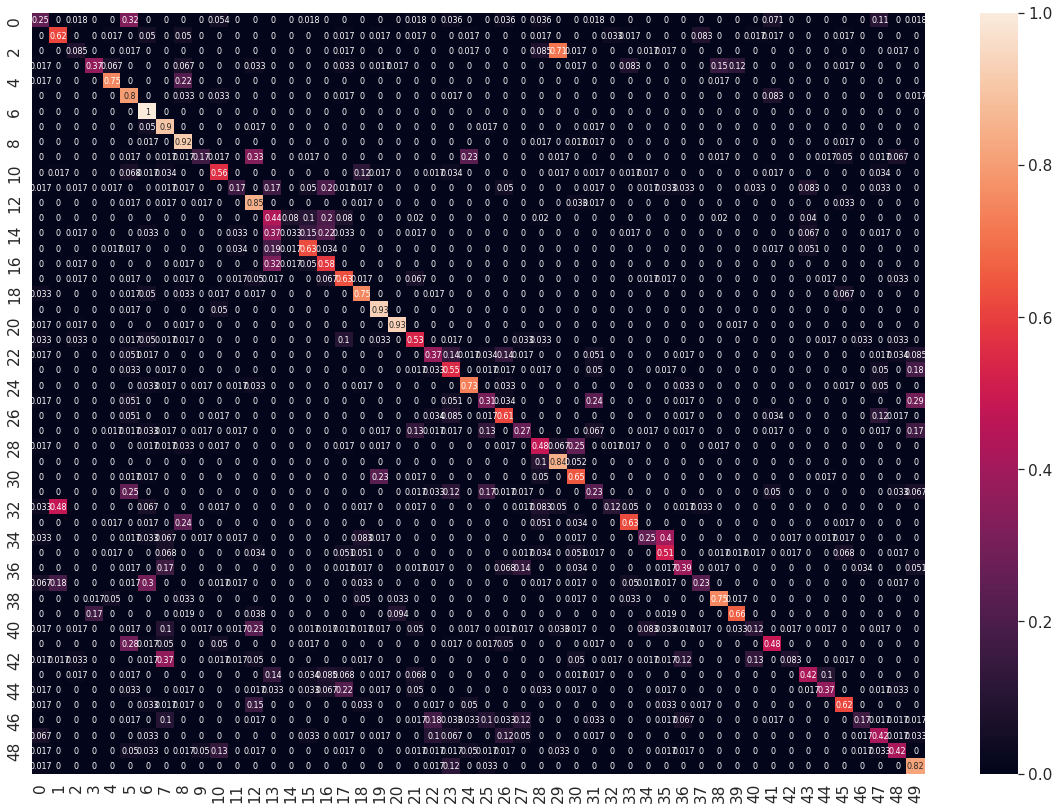

In [27]:
#Output visualization: The confusion Matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
sn.set(font_scale=1.4) # for label size
plt.figure(figsize = (20,14))
sn.heatmap(df_cm,annot=True, annot_kws={"size": 8}) # font size

plt.show()

### Next, for comparative purposes, lets evaluate what would have happened if we had just used ridge regression.

### Let's calculate $W$ and $\hat{y}$ using ridge regression, i.e. $W = (XX^{T}+\alpha I)^{-1} \cdot X \cdot Y$, $\hat{y} = \arg \max (X^{T} W)$

In [28]:
#Step 1: Lets initialize W and alpha
W=np.zeros((n_features,gt_trainval.shape[1]))
alpha2=alph1

## Task 7: Compute W vector using ridge regression and teh equation above

In [29]:
######START CODE HERE#########
XXTA2T= np.linalg.pinv(np.matmul(trainval_features, trainval_features.T)+ alpha2*np.eye(n_features))
W = np.matmul(np.matmul(XXTA2T, trainval_features), gt_trainval)
##########END CODE HERE############
print(W.shape)

(2048, 150)


In [30]:
#Next Now lets evaluate (y_hat=preds_2) using the W and features already computed!
##########START CODE HERE############
y_preds2 = np.matmul(test_features.T, W)
preds_2 = np.array([np.argmax(y_pred2) for y_pred2 in y_preds2])
#########END CODE HERE##################
#Look at a sample prediction, same sample (num) as the ZSL example above
print('Normal Regression Predicted label=',preds_2[num])
print('Actual Label=',labels_test[num])

Normal Regression Predicted label= 72
Actual Label= [32]


### Step 4: Evaluation using 1 in % accuracy and confusion matrix.
Evaluating the performance of ZSL models is tricky since the model has never previously see the exact test labels. (See example in https://github.com/cetinsamet/zero-shot-learning). Thus, based on the signature vector, the model predicts several outcomes. If top 5 outcomes are predicted then the metric is refered to as top 5 in % accuracy. Similarly if top 3 outcomes are predicted, metric is top 3 in % accuracy. 

In [31]:
### Create a confusion matrix between actual labels(labels_test) and predictions (preds_2)
#####START CODE HERE##########################
cm2 = confusion_matrix(labels_test, preds_2) #insert the command for confusion matrix
##########END CODE HERE########################
cm2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
cm2=np.nan_to_num(cm2,nan=0)
avg2 = sum(cm2.diagonal())/len(test_labels_unseen)
print("The top 1% accuracy is:", avg2*100)

The top 1% accuracy is: 0.359748427672956


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


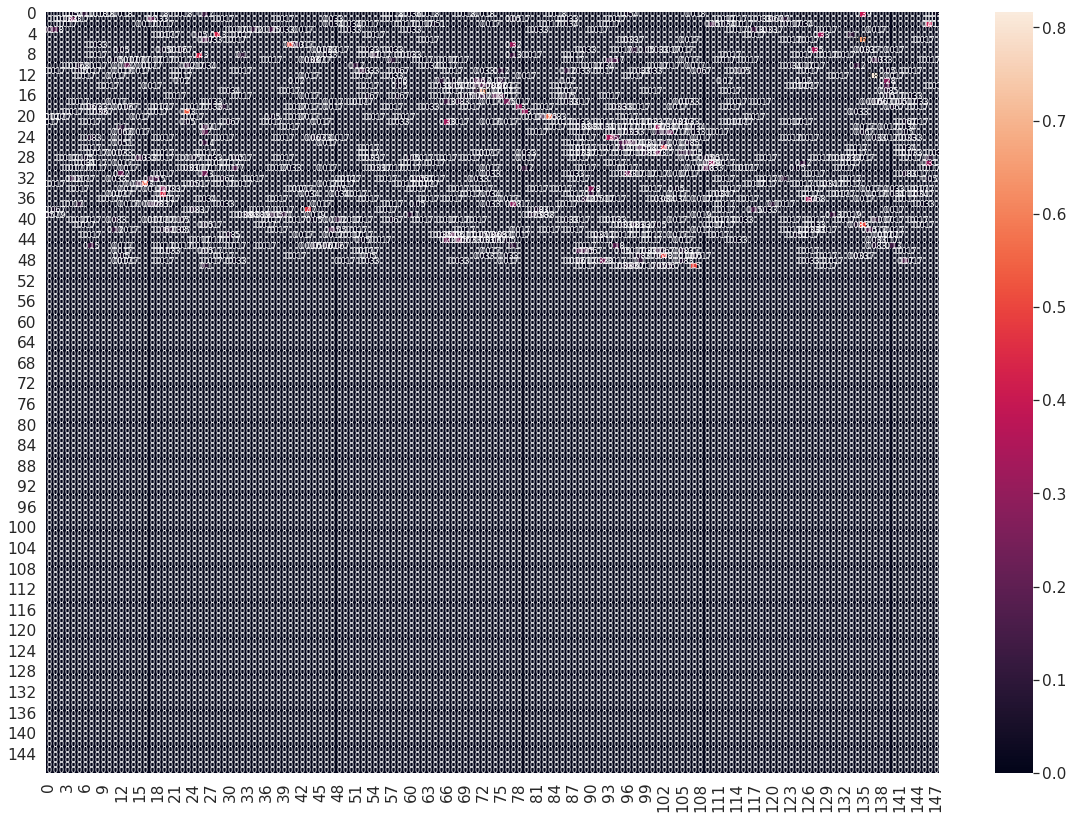

In [32]:
#Lets visualize confusion matrix. Observe too many 0 values in the confusion matrix
df_cm2 = pd.DataFrame(cm2, range(cm2.shape[0]), range(cm2.shape[1]))
sn.set(font_scale=1.4) # for label size
plt.figure(figsize = (20,14))
sn.heatmap(df_cm2,annot=True, annot_kws={"size": 8}) # font size

plt.show()

## So we see that the use of vectorization and signature matrix yields Zero Shot Learning 1% Accuracy of  55.14% for unseen data as opposed to <1% accuracy that can be obtained by ridge regression only.

# Thus, we see the given method method using signature matrix is highly useful for previously unseen data!

## Finally, lets try some hyper-parameter tuning!
### Below code snippet can be used to find the best hyper-parameter using the train and val set. This can be used to set alpha1, gamma1 in the equations above.
### Run the following snippet to obtain the best alpha1 and gamma1 and substitute in the zero shot learning cells (After " Zero Shot Learning begins here!"). Report the performance improvement by using the optimal hyper-parameters.

In [34]:
accu = 0.10
alph1 = 4
gamm1 = 1
for alpha in range(-3, 4):
    for gamma in range(-3,4):
        #One line solution
        part_1 = np.linalg.pinv(np.matmul(train_features, train_features.transpose()) + (10**alpha)*np.eye(n_features))
        part_0 = np.matmul(np.matmul(train_features,gt_train),train_sig.transpose())
        part_2 = np.linalg.pinv(np.matmul(train_sig, train_sig.transpose()) + (10**gamma)*np.eye(n_attributes))

        V = np.matmul(np.matmul(part_1,part_0),part_2)
        #print(V)

        #predictions
        outputs = np.matmul(np.matmul(val_features.transpose(),V),val_sig)
        preds = np.array([np.argmax(output) for output in outputs])

        cm = confusion_matrix(labels_val, preds)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        avg = sum(cm.diagonal())/len(val_labels_unseen)
        print("Avg:", avg, alpha, gamma)

        if avg > accu:
            accu = avg
            alph1 = alpha
            gamm1 = gamma
print('Optimal Alpha=',alph1, 'Optimal Gamma=',gamm1)

Avg: 0.18585450209673038 -3 -3
Avg: 0.24968040478867645 -3 -2
Avg: 0.34653258722533276 -3 -1
Avg: 0.4093230883557413 -3 0
Avg: 0.3892262675964993 -3 1
Avg: 0.38704134343461916 -3 2
Avg: 0.3531400601840633 -3 3
Avg: 0.18585450209673038 -2 -3
Avg: 0.24968040478867645 -2 -2
Avg: 0.34703258722533276 -2 -1
Avg: 0.4093230883557413 -2 0
Avg: 0.3888341107337542 -2 1
Avg: 0.38704134343461916 -2 2
Avg: 0.3527052775753677 -2 3
Avg: 0.18585450209673038 -1 -3
Avg: 0.2501233053531576 -1 -2
Avg: 0.34703258722533276 -1 -1
Avg: 0.4093230883557413 -1 0
Avg: 0.38926889334244985 -1 1
Avg: 0.38661581151972557 -1 2
Avg: 0.3535563414051549 -1 3
Avg: 0.18711892762812204 0 -3
Avg: 0.2551315135698468 0 -2
Avg: 0.3523568358486893 0 -1
Avg: 0.41178783716475353 0 0
Avg: 0.39021185318408413 0 1
Avg: 0.3882897513282071 0 2
Avg: 0.3577092836277689 0 3
Avg: 0.2129903057974815 1 -3
Avg: 0.2750085113017567 1 -2
Avg: 0.3811041180952309 1 -1
Avg: 0.437161019212587 1 0
Avg: 0.4167186252556304 1 1
Avg: 0.4057926011892311 1 

# Zero Shot Learning with optimal hyper-parameters

In [41]:
#Initialization. This is where optimal hyper parameters are set!
n_features = trainval_features.shape[0]
n_attributes = trainval_sig.shape[0]
V = np.zeros((n_features,n_attributes))

print(V.shape)
#Note: These hyperparameters should be changed to optiomal versions after implementing the last code cell
gamm1 = 0
alph1 = 3

(2048, 312)


In [42]:
##Using the formulation for V above, compute V
XXTAI = np.linalg.pinv(np.matmul(trainval_features, trainval_features.T) + (10**alph1)*np.eye(n_features))
XYST = np.matmul(np.matmul(trainval_features, gt_trainval), trainval_sig.T)
SSTGI = np.linalg.pinv(np.matmul(trainval_sig, trainval_sig.T)+ (10**gamm1)*np.eye(n_attributes))
V = np.matmul(np.matmul(XXTAI, XYST), SSTGI)

In [43]:
# Predicting y_hat = preds_1
y_preds = np.matmul(np.matmul(test_features.T, V), test_sig)
preds_1 = np.array([np.argmax(y_pred) for y_pred in y_preds])

In [44]:
### Create a confusion matrix between actual labels(labels_test) and predictions (preds_1)
cm = confusion_matrix(labels_test, preds_1) #insert the command for confusion matrix
print("Shape of Confusion Matric is=",np.shape(cm))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
avg = sum(cm.diagonal())/len(test_labels_unseen)
print("The top 1% accuracy is:", avg*100) #This is the definition of top 1% accuracy

Shape of Confusion Matric is= (50, 50)
The top 1% accuracy is: 51.91533906969492


## Report:
#### Before hyperparameter tuning, the top 1% accuracy is about 50.77%
#### After hyperparameter tuning, the top 1% accuracy is about 51.92%

Clearly there is a performance improvement with the optimal hyper-parameter tuning.